<a href="https://colab.research.google.com/github/A3labmarche/DL4SP_notebooks/blob/main/KWS_CNN_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Keyword Spotting with Convolutional Neural Network


Word utterances recognition network, trained on one-second wav audio clips from [Google Speech Command](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) dataset.
<br><br>
Carlo Aironi<br>
c.aironi@pm.univpm.it<br>
2021


## Import libraries

In [ ]:
import os
import time
import itertools
import librosa
import numpy as np
import tqdm.notebook as tq
import pandas as pd
import csv

import multiprocessing
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [ ]:
data_path = '/GSC_v1_10'
melsp_ndarray = 'gsc110_melspecs.npy'
meta_file = 'gsc110_meta.pkl'

classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

SAMPLE_RATE = 16000
EXP_SAMPLES = 16000

# split train/validation partition percentage
TRAIN_PART = 0.8
VAL_PART = 0.2

FFT_SIZE = 1024
FFT_HOP = 128
FFT_MEL_BANDS = 64

EXP_H = 64
EXP_W = 126

BATCH_SIZE = 256
LEARNING_RATE = 5e-3
EPOCHS = 50

Define computation environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available environment: {device}')

Current environment: cuda


## Download data, parse and generate meta-file

In [ ]:
# The data will be downloaded to a temporary folder
!wget -nc http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir -p /GSC_v1_10 && tar -xf speech_commands_v0.01.tar.gz -C /GSC_v1_10

--2021-11-29 15:07:09--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.103.128, 2607:f8b0:4001:c2b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.103.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  89.2MB/s    in 17s     

2021-11-29 15:07:26 (85.1 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



the meta-data informations will be used to manage the flow of data through the network:
- `filepath`: relative path to wav file
- `category`: numeric class label, 0 to 9
- `train`: flag
- `validation`: flag
- `test`: flag

In [ ]:
mymeta = pd.DataFrame(columns=('filepath', 'category', 'train', 'validation', 'test'))
print('Parse dataset and generate meta file\n')
for ci, category in enumerate(classes):
    print(f'class "{category}"')
    source_path = os.path.join(data_path, category)
    nwav = len(os.listdir(source_path))
    split_indices = np.random.choice(2, nwav, p=[TRAIN_PART, VAL_PART]) # generate tensor of indices for train/validation split
    for wav_index, wavfile in enumerate(tq.tqdm(os.listdir(source_path))): 
        mymeta = mymeta.append({'filepath': os.path.join(category,wavfile),
                                  'category': ci,
                                  'train': 1 if split_indices[wav_index] == 0 else 0 ,
                                  'validation': 1 if split_indices[wav_index] == 1 else 0 ,
                                  'test': 1 if split_indices[wav_index] == 2 else 0 },ignore_index=True)
mymeta.to_pickle(meta_file)

print('done')

Parse dataset and generate meta file

class "zero"


  0%|          | 0/2376 [00:00<?, ?it/s]

class "one"


  0%|          | 0/2370 [00:00<?, ?it/s]

class "two"


  0%|          | 0/2373 [00:00<?, ?it/s]

class "three"


  0%|          | 0/2356 [00:00<?, ?it/s]

class "four"


  0%|          | 0/2372 [00:00<?, ?it/s]

class "five"


  0%|          | 0/2357 [00:00<?, ?it/s]

class "six"


  0%|          | 0/2369 [00:00<?, ?it/s]

class "seven"


  0%|          | 0/2377 [00:00<?, ?it/s]

class "eight"


  0%|          | 0/2352 [00:00<?, ?it/s]

class "nine"


  0%|          | 0/2364 [00:00<?, ?it/s]

done


## Generate CNN dataset

Each time-domain wav file is converted to logMEL-scale spectrogram, then saved for training.

Due to the large amount of files, computations are performed in a multi-cpu fashion.

In [ ]:
def gen_spec(idx):
  clip, _ = librosa.load(os.path.join(data_path, mymeta.iloc[idx].filepath), sr=SAMPLE_RATE)
  if len(clip) > EXP_SAMPLES: # trim to 1s
      clip = clip[0:EXP_SAMPLES]
  elif len(clip) < EXP_SAMPLES: # pad to 1s
      clip = np.pad(clip, (0, EXP_SAMPLES - len(clip)), 'constant', constant_values=(0,0))
  melsp = librosa.feature.melspectrogram(clip,
                                          sr=SAMPLE_RATE,
                                          n_fft=FFT_SIZE,
                                          hop_length=FFT_HOP,
                                          power=2,
                                          n_mels=FFT_MEL_BANDS,
                                          fmax=SAMPLE_RATE/2)
  logmelsp = librosa.power_to_db(melsp, ref=np.max)     # transform to log_mel_spectrogram
  logmelsp = logmelsp.astype(np.float32)                # convert data type to match with pytorch network model
  logmelsp = logmelsp.flatten()[:, np.newaxis].T        # flatten
  return logmelsp

In [ ]:
CPU_COUNT = multiprocessing.cpu_count()
mymeta = pd.read_pickle(meta_file)
rows_logmelsp = []
print(f'Start extracting spectrograms using {CPU_COUNT} CPUs')
rows_logmelsp.extend(Parallel(n_jobs=CPU_COUNT)(delayed(gen_spec)(i) for i in tq.tqdm(range(len(mymeta)))))
rows_logmelsp = np.vstack(rows_logmelsp)
# Save to .npy file to a temporary folder
np.save(melsp_ndarray, rows_logmelsp)
print('done')

Start extracting spectrograms using 2 CPUs


  0%|          | 0/23666 [00:00<?, ?it/s]

done


## Data loading function

In [ ]:
def data_load():
    print('Loading data...')

    X_train =[]
    y_train = []
    X_val = []
    y_val = []

    # Read meta and data files
    meta_data = pd.read_pickle(os.path.join(meta_file))
    melspec_data = np.load(os.path.join(melsp_ndarray))
    
    # Split samples ito train/validation set according to meta file indices
    for idx in range(melspec_data.shape[0]):
        meta_data_item = meta_data.iloc[idx]
        melspec_data_item = melspec_data[idx]
        melspec_data_item = melspec_data_item.reshape(EXP_H,EXP_W)      # reshape flattened spectrograms

        if meta_data_item.train == 1:                 # if Train in meta
            X_train.append(melspec_data_item)         # spectrogram
            y_train.append(meta_data_item.category)   # label

        elif meta_data_item.validation == 1:          # if Validation in meta
            X_val.append(melspec_data_item)           # spectrogram
            y_val.append(meta_data_item.category)     # label

    # convert lists to Torch tensors
    X_train = torch.FloatTensor(np.array(X_train))      # data must be float
    y_train = torch.LongTensor(y_train)       # labels must be long
    X_val = torch.FloatTensor(np.array(X_val))
    y_val = torch.LongTensor(y_val)

    # wrap data and labels in a torch dataset object
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

    # create dataloader objects
    train_dataload = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_dataload = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True, num_workers=2) # full batch for validation

    print(f'{len(train_dataset)} items for training ({len(train_dataload)} batches of {BATCH_SIZE} items)')
    print(f'{len(val_dataset)} items for validation (1 batch of {len(val_dataset)} items)')       

    return train_dataload, val_dataload

## Network model



A PyTorch network model is defined extending the `nn.Module` class and defining at least two methods: `__init__()` and `forward()`.

- `__init__()` (constructor) defines network layers and parameters.

- `forward()` defines connections and data flow between layers.

A 2-D convolution is performed by the library function `nn.Conv2d()`, which requires the following parameters:
- __Input size__ (mandatory), C (channel dimension) of the input image
- __Output size__ (mandatory) number of convolutional filters to be used
- __Kernel size__ (mandatory), dimensions of each conv filter.

There are also other optional parameters, which if not specified assume default values as reported in the documentation; in this case one parameter is explicitly defined:

- __Padding__: zero values placed around the image, to fix output dimensions.

Each layer receives the input from the previous layer and in order not to generate errors, its parameters must be properly set. The PyTorch documentation shows the formulas for calculating the output dimensions from a Conv2d layer (PyTorch adopts the notation __(N, C, H, W)__ to denote the axes order of a 4-dimensional array, where __N__ is the batch-size, __C__ is the channel size, __H__ and __W__ are, respectively, the height and width of the image):

- Input: $\left(N, C_{in}, H_{in}, W_{in} \right)$
- Output: $\left(N, C_{out}, H_{out}, W_{out} \right)$<br>
where

$H_{out}=\lfloor\frac{H_{in}+2\cdot\text{padding[0]}-\text{dilation[0]}\cdot (\text{kernel_size[0]}-1)-1}{\text{stride[0]}}+1\rfloor$

$W_{out}=\lfloor\frac{W_{in}+2\cdot\text{padding[1]}-\text{dilation[1]}\cdot (\text{kernel_size[1]}-1)-1}{\text{stride[1]}}+1\rfloor$

Each _Sequential_ layer contains a convolutional block which includes, in addition to the actual convolution:

- A `BatchNorm2D` layer, which performs regularization and speed up convergence.
- A `ReLU` activation layer
- A `MaxPool2d` layer, which undersamples the image to shrink dimensions and reduce calculations.

At the end of the convolutional block, two _Dense_ (or _fully connected_) layers perform the actual classification on the previously extracted features. The _dropout_ layer allows better _regularization_ and helps to reduce _overfitting_.


In [ ]:
class my_ConvNet(nn.Module):
    def __init__(self):
        super(my_ConvNet, self).__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer_3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.fc_1 = nn.Linear(64 * 16 * 31, 128)
        self.drop_out = nn.Dropout()
        self.fc_2 = nn.Linear(128, 10)           # 10 outputs for 10-class classification

    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = out.view(out.size(0), -1)         # reshape
        out = self.fc_1(out)
        out = self.drop_out(out)
        out = self.fc_2(out)
        
        return out


Print network structure in a readable format

In [ ]:
dummy_net = my_ConvNet().to(device)
summary(dummy_net, input_size=(1, 64, 126))
del dummy_net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 126]             320
       BatchNorm2d-2          [-1, 32, 64, 126]              64
              ReLU-3          [-1, 32, 64, 126]               0
         MaxPool2d-4           [-1, 32, 32, 63]               0
            Conv2d-5           [-1, 64, 32, 63]          18,496
       BatchNorm2d-6           [-1, 64, 32, 63]             128
              ReLU-7           [-1, 64, 32, 63]               0
         MaxPool2d-8           [-1, 64, 16, 31]               0
            Conv2d-9           [-1, 64, 16, 31]          36,928
      BatchNorm2d-10           [-1, 64, 16, 31]             128
             ReLU-11           [-1, 64, 16, 31]               0
           Linear-12                  [-1, 128]       4,063,360
          Dropout-13                  [-1, 128]               0
           Linear-14                   

## Helper functions

In [ ]:
def plot_curve(train_accs, val_accs, train_losss, val_losss):
    plt.figure(1, figsize=[10, 6])

    plt.subplot(211)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    # plt.ylim([0.25, 1])
    plt.legend(loc='lower left')

    plt.subplot(212)
    plt.plot(train_losss, label='Train Loss')
    plt.plot(val_losss, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    # plt.ylim([0.0, 2.5])
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_cmatrix(true_labels, pred_labels, normalize):

    cm = confusion_matrix(true_labels.cpu(), pred_labels.cpu())
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(1, figsize=[8, 8])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix' if normalize else 'Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Train and Validation functions

In [ ]:
def train(model, optimizer, criterion, train_dataload):
  # set all network parameters to train mode
  model.train()

  epoch_loss = 0.0
  correct = 0

  for inputs, labels in train_dataload:

      # add channel dimension C
      inputs = inputs.unsqueeze(1) 
      
      # Send data to device: cuda or cpu
      inputs = inputs.to(device)
      labels = labels.to(device)
          
      # Set the parameter gradients to zero
      optimizer.zero_grad()
          
      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # backward gradients propagation
      loss.backward()

      # optimization (update weights)
      optimizer.step()
          
      # accumulate loss
      epoch_loss += loss.item()
          
      # Track the train accuracy
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()

  # compute mean loss and overall accuracy for the whole batch
  epoch_mean_loss = epoch_loss / len(train_dataload)
  epoch_acc = correct / len(train_dataload.dataset)

  return epoch_mean_loss, epoch_acc


def validate(model, criterion, val_dataload):
  # set all network parameters to no-train mode
  model.eval()

  epoch_loss = 0.0
  correct = 0

  with torch.no_grad():  # set the require_grad = false for validation

    for inputs, labels in val_dataload:

        # add channel dimension C
        inputs = inputs.unsqueeze(1)
        
        # Send data to device: cuda or cpu
        inputs = inputs.to(device)
        labels = labels.to(device) 

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # accumulate loss
        epoch_loss += loss.item()
        
        # track the validation accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

  # compute mean loss and overall accuracy for the whole batch
  epoch_mean_loss = epoch_loss / len(val_dataload)
  epoch_acc = correct / len(val_dataload.dataset)

  # return true and predicted labels for confusion matrix final plot
  return epoch_mean_loss, epoch_acc, labels, predicted

## Start experiment

In [ ]:
def start_experiment(plots, cmatrix):

    # define net object
    net = my_ConvNet().to(device)        

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

    # generate dataloader
    train_dataload, val_dataload = data_load()

    print(f'Start training with {device}')

    n_batches = len(train_dataload)
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
      
    # get timestamp
    training_start_time = time.time()

    # loop for EPOCHS
    for epoch in range(EPOCHS):
        epoch_time = time.time()

        # Learning rate step reduction
        if epoch == 280:                                # reduce lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2e-3
        if epoch == 325:                                # reduce lr further
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5e-4

        epoch_train_loss, epoch_train_acc = train(net, optimizer, criterion, train_dataload)

        print(f'Epoch {epoch + 1}/{EPOCHS} - Train Loss: {epoch_train_loss:.3f} - Train Accuracy: {100*epoch_train_acc:.2f} % - ', end='')

        # track the train loss and accuracy
        train_loss_list.append(epoch_train_loss)
        train_acc_list.append(epoch_train_acc)
                
        # at the end of the epoch do a pass on the validation set
        epoch_val_loss, epoch_val_acc, true_labels, pred_labels = validate(net, criterion, val_dataload)

        print(f'Validation Loss: {epoch_val_loss:.3f} - Validation Accuracy: {100*epoch_val_acc:.2f} % - Elapsed time: {(time.time() - epoch_time):.2f} s')
        
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc)
            
    print('-'*20)
    print(f'Training finished, Total elapsed time {(time.time() - training_start_time):.2f} s\n\n')

    if plots:
        try:
            plot_curve(train_acc_list, val_acc_list, train_loss_list, val_loss_list)
        except Exception as e:
            print(f'An error occurred during plot_curve execution: {e}')

    print('-'*20)

    if cmatrix:
        try:
            plot_cmatrix(true_labels, pred_labels, normalize=True)
        except Exception as e:
            print(f'An error occurred during plot_cmatrix execution: {e}')

    return train_acc_list, train_loss_list, val_acc_list, val_loss_list, net

Loading data...
18908 items for training (74 batches of 256 items)
4758 items for validation (1 batch of 4758 items)
Start training with cuda
Epoch 1/50 - Train Loss: 11.187 - Train Accuracy: 46.72 % - Validation Loss: 1.359 - Validation Accuracy: 64.31 % - Elapsed time: 20.33 s
Epoch 2/50 - Train Loss: 1.023 - Train Accuracy: 70.67 % - Validation Loss: 0.789 - Validation Accuracy: 75.77 % - Elapsed time: 19.89 s
Epoch 3/50 - Train Loss: 0.700 - Train Accuracy: 78.56 % - Validation Loss: 0.592 - Validation Accuracy: 83.04 % - Elapsed time: 19.66 s
Epoch 4/50 - Train Loss: 0.560 - Train Accuracy: 83.17 % - Validation Loss: 0.439 - Validation Accuracy: 87.20 % - Elapsed time: 19.65 s
Epoch 5/50 - Train Loss: 0.441 - Train Accuracy: 86.36 % - Validation Loss: 0.391 - Validation Accuracy: 88.50 % - Elapsed time: 19.83 s
Epoch 6/50 - Train Loss: 0.379 - Train Accuracy: 88.71 % - Validation Loss: 0.333 - Validation Accuracy: 90.94 % - Elapsed time: 19.74 s
Epoch 7/50 - Train Loss: 0.307 - Tr

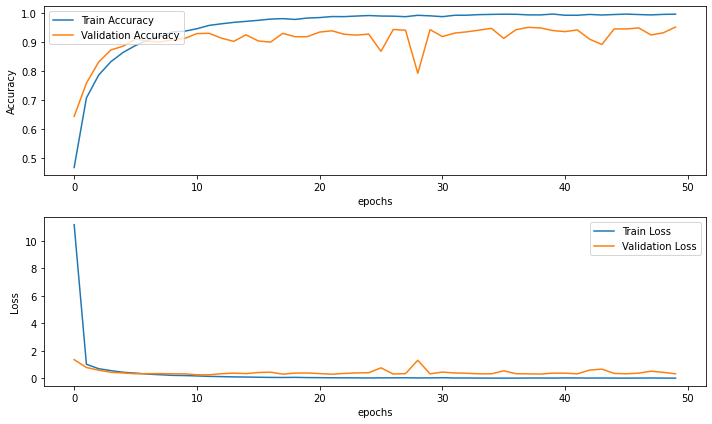

--------------------


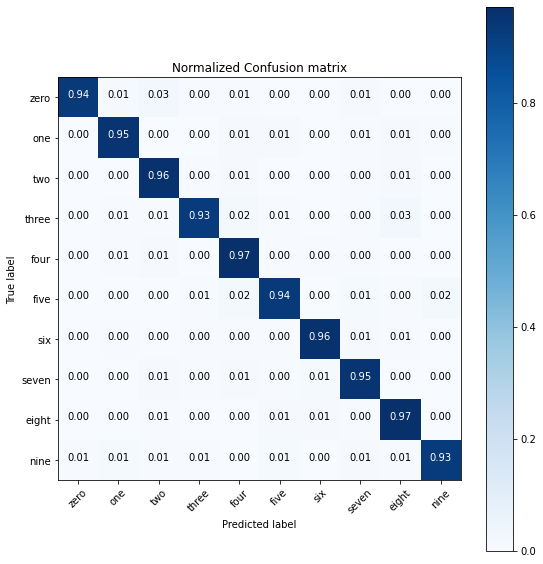

In [ ]:
final_train_acc, final_train_loss, final_val_acc, final_val_loss, trained_net = start_experiment(plots=True, cmatrix=True)

Save performance values to csv

In [ ]:
perf_dict = {'TRAIN_ACCURACY': final_train_acc,
             'TRAIN_LOSS': final_train_loss,
             'VAL_ACCURACY': final_val_acc,
             'VAL_LOSS': final_val_loss}

df = pd.DataFrame(perf_dict)

df.to_csv('perf.csv')



---


